# Graphing Elevation Profile with ArcGIS Python API

Contributors: Jia-Shen Tsai, Wendy Wen, Zhengqi Jiao, Miaojun Pang,
Alexander Yoshizumi

Last Updated: 2023-12-10

Description: When run, script downoad the data and 

In [1]:
#import library
from arcgis import GIS
from arcgis.features import FeatureLayer, FeatureSet, GeoAccessor
from arcgis.features import elevation as elev                       #Link to elevation tools

# Authenticate with your ArcGIS Online or ArcGIS Enterprise account
gis = GIS('home')

In [34]:
# #call the latest data (failed because the layers from FeatureService is puzzling)
# tracksLayer = FeatureLayer("https://geo.dot.gov/server/rest/services/Hosted/Amtrak_Routes_DS/FeatureServer/0/query?outFields=*&where=1%3D1")
# sdf_route = GeoAccessor.from_layer(routeAll)

In [35]:
# results = gis.content.search(query='Amtrak Routes owner:USDOT_BTS',
#                             outside_org=True)
# results

In [36]:
# tracksItem = results[0]
# type(tracksItem)

In [37]:
# tracksLayer = tracksItem.layers[0]

In [38]:
# type(tracksLayer)

In [39]:
# print([fld.name for fld in tracksLayer.properties.fields])

In [40]:
# fset_Carolinian = tracksLayer.query(where="name='Carolinian'")

In [41]:
# another way to read the data: read the data from local
sdf_tracks = GeoAccessor.from_featureclass('../01_Data/01_Source/Amtrak_Routes/amtrak_routes_ds_amtrak_june_18_2019.shp')

In [42]:
sdf_tracks.head()

,FID,objectid,name,shape_leng,shape_le_1,shape_Le_2,SHAPE
0,0,1,Acela,7.410105e+05,7.410105e+05,7.895401,"{""paths"": [[[-77.01421481299997, 38.8836032980..."
1,1,2,Adirondack,6.156754e+05,6.156754e+05,6.013791,"{""paths"": [[[-73.74197248699994, 42.6402762260..."
2,2,3,Auto Train,1.474024e+06,1.474024e+06,14.082956,"{""paths"": [[[-81.31769915799998, 28.7589285180..."
3,3,4,Blue Water,5.114384e+05,5.114384e+05,5.834930,"{""paths"": [[[-87.63610084199996, 41.8177249360..."
4,4,5,California Zephyr,4.313889e+06,4.313889e+06,47.246098,"{""paths"": [[[-108.55590727399999, 39.062632268..."


In [43]:
#Subset one line to do the calculation
fset_Carolinian = sdf_tracks.query('name == "Carolinian"')
len(fset_Carolinian)

1

In [44]:
#IF I use the feature layer found by searching online is content, it'll be feature set
#If directly read in with GeoAccessor , it'll be df
#both formats could work in the following elev.profile function
type(fset_Carolinian)

pandas.core.frame.DataFrame

In [45]:
#Compute the profile with fset_Carolinian
profile_fset = elev.profile(
    input_line_features = fset_Carolinian,
    dem_resolution = '30m',
    maximum_sample_distance = 1000,
    maximum_sample_distance_units = 'Meters'
)

In [46]:
type(profile_fset)

arcgis.features.feature.FeatureSet

In [47]:
profile_sdf = profile_fset.sdf
profile_sdf

,OBJECTID,DEMResolution,ProductName,Source,Source_URL,ProfileLength,Shape_Length,SHAPE
0,1,30m,NED_1_arcsec,USGS,http://ned.usgs.gov/,869868.797056,8.745682,"{""paths"": [[[-78.2593484776275, 35.54109777395..."


In [48]:
elev_summary = elev.summarize_elevation(
    input_features = fset_Carolinian,
    dem_resolution = '30m',
    include_slope_aspect = True
)

In [49]:
type(elev_summary)

arcgis.features.feature.FeatureSet

In [50]:
elev_summary_sdf = elev_summary.sdf
elev_summary_sdf

,FID,name,shape_leng,shape_le_1,shape_Le_2,ID,MinElevation,MeanElevation,MaxElevation,MinSlope,MeanSlope,MaxSlope,MeanAspect,DEMResolution,ProductName,Source,Source_URL,Shape_Length,SHAPE
0,1,Carolinian,0.0,871554.626039,8.745682,1,-4.464453,30.67496,122.447281,0.0,2.074866,24.175549,138.785329,30m,NED_1_arcsec,USGS,http://ned.usgs.gov/,8.745682,"{""paths"": [[[-78.25934847733839, 35.5410977735..."


# Clipping NC Routes Out with arcpy

In [51]:
import arcpy

In [52]:
#pip install geopandas
#pip install contextily
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

In [53]:
# Set workspace
arcpy.env.workspace = "../01_Data/01_Source/"
arcpy.env.overwriteOutput = True

In [54]:
# Input polyline feature class
input_fc = "Amtrak_Routes/amtrak_routes_ds_amtrak_june_18_2019.shp"
output_fc = "../01_Data/02_Processed/Amtrak_Route_NC.shp"
nc_boundary = "NC_Boundary/NCDOT_State_Boundary.shp"

In [55]:
arcpy.analysis.Clip(input_fc, nc_boundary, output_fc)

<Result '..\\01_Data\\02_Processed\\Amtrak_Route_NC.shp'>

In [56]:
nc_tracks_gdf = gpd.read_file("../01_Data/02_Processed/Amtrak_Route_NC.shp")

In [57]:
nc_tracks_gdf.crs.to_string()

'EPSG:4326'

SSLError: HTTPSConnectionPool(host='a.tile.openstreetmap.fr', port=443): Max retries exceeded with url: /hot/8/72/99.png (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1129)')))

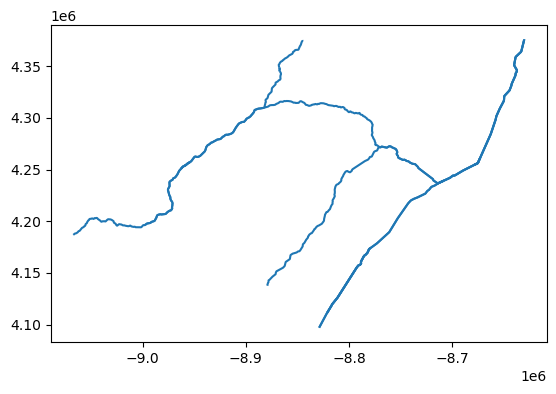

In [58]:
route_plot = nc_tracks_gdf.to_crs(3857).plot()
ctx.add_basemap(route_plot)

In [59]:
nc_tracks_gdf.head()

,objectid,name,shape_leng,shape_le_1,shape_Le_2,geometry
0,3,Auto Train,1.474024e+06,1.474024e+06,14.082956,"MULTILINESTRING ((-79.31281 34.50569, -79.3128..."
1,31,Silver_Service/Palmetto,2.984346e+06,2.984346e+06,29.026557,"MULTILINESTRING ((-79.31281 34.50569, -79.3128..."
2,37,Crescent,2.230998e+06,2.230998e+06,22.651323,"MULTILINESTRING ((-81.45065 35.16823, -81.4499..."
3,46,Carolinian,0.000000e+00,8.715546e+05,8.745682,"MULTILINESTRING ((-78.25935 35.54110, -78.2566..."
4,47,Piedmont,0.000000e+00,2.882651e+05,2.980784,"MULTILINESTRING ((-80.82749 35.23796, -80.8273..."


In [60]:
mask = (nc_tracks_gdf["name"] == 'Carolinian')
carolinian_gdf = nc_tracks_gdf[mask]
type(carolinian_gdf)

geopandas.geodataframe.GeoDataFrame

## download the carolinian route in NC as a shp

In [61]:
carolinian_sdf = GeoAccessor.from_geodataframe(carolinian_gdf)

In [62]:
carolinian_item = carolinian_sdf.spatial.to_featurelayer()

KeyboardInterrupt: 

In [ ]:
# carolinian_shp = carolinian_item.export(title='carolinian', export_format='Shapefile')
# carolinian_shp.download("../01_Data/02_Processed")

# Access Amtrak Stations

In [8]:
stationItem = gis.content.get("6ad5c20bbc44441cb7777c83928dc0c0")
fl_station = stationItem.layers[0]

In [3]:
print([fld.name for fld in fl_station.properties.fields])

['FID', 'objectid_1', 'OBJECTID', 'statype', 'stntype', 'zipcode', 'STATE', 'city', 'address2', 'address1', 'name', 'code', 'stationnam']


In [13]:
#Subset records that are in NC
fs_NCStation = fl_station.query(where="STATE = 'NC' AND stntype = 'TRAIN'")
len(fs_NCStation)

18

In [5]:
#Map the feature set with 'draw'
map2 = gis.map('North Carolina')
map2.basemap = 'osm'
map2.draw(fs_NCStation, popup={'title':'stationnam','content':'code'})
map2.zoom=8
map2

MapView(layout=Layout(height='400px', width='100%'))

In [15]:
sdf_NCStation = fs_NCStation.sdf
fs_NCStation.save(
    save_location='../01_Data/02_Processed',
    out_name='NCStation'
)

'..\\01_Data\\02_Processed\\NCStation.shp'

# Access NC DEM

In [ ]:
ncDEM_item = gis.content.get("ba63c5fbce124e21bbb50f7e3cd849b0")
ncDEM_img = ncDEM_item.layers[0]

In [ ]:
import arcgis.raster

In [ ]:
ncDEM_img.export_image(
    export_format="tiff",
    f="image",
    save_folder="../01_Data/01_Source",
    save_file="ncDEM.tif")

# Read all json data

In [67]:
import pandas as pd

In [ ]:
# # data inspection
# df = pd.read_json('../01_Data/01_Source/ASM/2023_11_12_14_45_11_107617.json')
# for i in df['location']:
#     print(i)

# # data subset 
# df_nc = df.query('name in ("Silver Meteor","Carolinian","Piedmont","Palmetto","Crescent")')
# df_nc.shape

# df_nc['current_timezone'].unique()

# # Extract latitude and longitude only from valid dictionaries
# def extract_coordinates(location):
#     if isinstance(location, dict):
#         return location.get('latitude'), location.get('longitude'), location.get('speed')
    else:
        return None, None, None

# %%capture --no-stdout
# df_nc[['latitude', 'longitude', 'speed']] = df_nc['location'].apply(extract_coordinates).apply(pd.Series)
# df_nc.head()

# sdf = GeoAccessor.from_xy(
#     df_nc,
#     x_column='longitude',
#     y_column='latitude'
# )

# #Create a geodataframe from the data
# gdf = gpd.GeoDataFrame(
#     data = sdf,
#     geometry = 'SHAPE',
#     crs = 4326)



In [68]:
# Extract latitude and longitude only from valid dictionaries
def extract_coordinates(location):
    if isinstance(location, dict):
        return location.get('latitude'), location.get('longitude'), location.get('speed')
    else:
        return None, None, None

In [70]:
# Read in clipping shp and 
gdf_county = gpd.read_file('../01_Data/01_Source/North_Carolina_State_and_County_Boundary_Polygons.zip').to_crs(4326)
# gdf_snap_nc = gpd.clip(gdf, gdf_county)
# gdf_snap_nc.head()

In [ ]:
# #Plot them with a base map
# status_plot = gdf_snap_nc.to_crs(3857).plot()
# ctx.add_basemap(status_plot)

In [75]:
import os
# import pandas as pd
# import geopandas as gpd
# from arcgis import GeoAccessor
# import warnings

# Use the warnings context manager to capture and suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  # Ignore all warnings
    # Define the folder path where JSON files are located
    json_folder = '../01_Data/01_Source/ASM'

    # Define the function to extract the lng, la, and speed only from valid dictionaries
    def extract_coordinates(location):
        if isinstance(location, dict):
            return location.get('latitude'), location.get('longitude'), location.get('speed')
        else:
            return None, None, None

    # Initialize an empty GeoDataFrame to store the combined data
    gdf_realop = gpd.GeoDataFrame()

    # Read and process each JSON file in the folder
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            json_filepath = os.path.join(json_folder, filename)

            # Read JSON file into a df
            df = pd.read_json(json_filepath)

            # Filter routes that pass nc and make lng, lat, speed to independent columns
            df_nc = df.query('name in ("Silver Meteor","Carolinian","Piedmont","Palmetto","Crescent")')
            df_nc[['latitude', 'longitude','speed']] = df_nc['location'].apply(extract_coordinates).apply(pd.Series)

            # Create a sdf
            sdf = GeoAccessor.from_xy(df_nc, x_column='longitude', y_column='latitude')

            # Create a gdf
            gdf = gpd.GeoDataFrame(data=sdf, geometry='SHAPE', crs=4326)

            # Clip the GeoDataFrame to the county boundary
            gdf_snap_nc = gpd.clip(gdf, gdf_county)

            # Append the clipped gdf to the combined gdf
            gdf_realop = gdf_realop.append(gdf_snap_nc, ignore_index=True)

# Remove duplicates based on name and location
gdf_realop = gdf_realop.drop_duplicates(subset=['name', 'latitude', 'longitude'])

gdf_realop.head()

,train_id,railroad,origin_date,number,all_numbers,name,origin,destination,partial_train,last_updated,current_timezone,threshold,disruption,total_miles,location,stops,latitude,longitude,speed,SHAPE
0,2023-11-12_AMTK_74,AMTRAK,2023-11-12,74,[74],Piedmont,CLT,RGH,False,1699818117,America/New_York,10,False,173,"{'latitude': 35.439048, 'longitude': -80.60831...","[{'code': 'CLT', 'miles': 0, 'sched_depart': 1...",35.439048,-80.608310,75.62,POINT (-80.60831 35.43905)
1,2023-11-12_AMTK_75,AMTRAK,2023-11-12,75,[75],Piedmont,RGH,CLT,False,1699818159,America/New_York,10,False,173,"{'latitude': 36.089347, 'longitude': -79.69185...","[{'code': 'RGH', 'miles': 0, 'sched_depart': 1...",36.089347,-79.691852,51.49,POINT (-79.69185 36.08935)
2,2023-11-12_AMTK_89,AMTRAK,2023-11-12,89,[89],Palmetto,NYP,SAV,False,1699818057,America/New_York,30,False,830,"{'latitude': 35.867607, 'longitude': -77.82821...","[{'code': 'NYP', 'miles': 0, 'sched_depart': 1...",35.867607,-77.828211,69.97,POINT (-77.82821 35.86761)
3,2023-11-12_AMTK_90,AMTRAK,2023-11-12,90,[90],Palmetto,SAV,NYP,False,1699818145,America/New_York,30,False,830,"{'latitude': 35.873291, 'longitude': -77.82513...","[{'code': 'SAV', 'miles': 0, 'sched_depart': 1...",35.873291,-77.825137,70.18,POINT (-77.82514 35.87329)
28,2023-11-12_AMTK_74,AMTRAK,2023-11-12,74,[74],Piedmont,CLT,RGH,False,1699818337,America/New_York,10,False,173,"{'latitude': 35.495498, 'longitude': -80.62470...","[{'code': 'CLT', 'miles': 0, 'sched_depart': 1...",35.495498,-80.624706,0.02,POINT (-80.62471 35.49550)


In [76]:
gdf_realop.shape

(191, 20)

In [77]:
gdf_realop = gdf_realop.set_geometry('SHAPE')

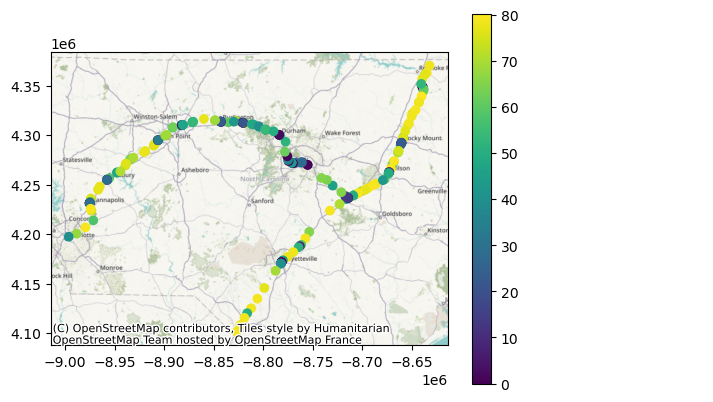

In [78]:
#Plot them with a base map
realop_plot = gdf_realop.to_crs(3857).plot(column='speed', legend=True)
ctx.add_basemap(realop_plot)

In [79]:
# Export the geodataframe to a CSV file
pd.DataFrame(gdf_realop).to_csv(
    '../01_data/02_Processed/realopNov12.csv',
    index=False
)